# Klastrowanie i uczenie nienadzorowane

<h1 id=tocheading>Spis treści</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# -*- coding: utf-8 -*-
"""
Demo of unicode support in text and labels.
"""
from __future__ import unicode_literals
from __future__ import print_function
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from sklearn.cross_validation import StratifiedKFold, KFold, train_test_split
from sklearn.datasets import load_svmlight_file, load_boston, make_blobs
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix
from sklearn import preprocessing
from sklearn.datasets import load_boston, load_diabetes, load_linnerud, make_regression
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3, make_sparse_uncorrelated
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples, completeness_contamination
from sklearn.cluster import KMeans
from sklearn import datasets

# Uczenie nienadzorowane
* zbiór danych $\{x_i\}_{i=1}^N$ ma $N$ obserwacji $p$-wymiarowej zmiennej o łącznym rozkładzie $P(X)$
* celem uczenia jest poznanie tego rozkładu __bez__ pomocy __nauczyciela__
  * często wymiarowość $p$ jest znacznie __wyższa__ od liczby przykładów, co utrudnia analizę
  * algorytmy typu PCA, multidimensional-scaling, samo-organizujących się map starają się zidentyfikować __niżej__ wymiarowe podprzestrzenie, które obejmują dane
  * algorytmy __klastrowania__ (__analizy skupisk__) wyszukują wiele wypukłych obszarów w $X$, które opisują charakterystyki danych
  * reguły asocjacyjne opisują gęste obszary danych za pomocą reguł koniunkcji

# Algorytmy klastrowania
* łączenie (lub dzielenie) przykładów w grupy tak, by przykłady w jednej grupie były bardziej do siebie podobne, niż te w różnych grupach
  * możliwe jest żądanie utworzenia __hierarchii__ grup
* centralną rolę pełni tu __miara podobieństwa__ (albo __niepodobieństwa__) przykładów
  * zwykle miary odległości są nieujemne oraz $\displaystyle d_{ii}=0$
  * zwykle algorytmy zakładają, że miary są symetryczne
    * jeśli zadana macierz odległości __nie__ jest syemtryczna, to należy ją zastąpić przez $\displaystyle (D+D^T)/2$
  * miary odległości zadane przez użytkowników często __nie__ spełniają nierówności trójkąta
    * niektóre algorytmy nie będą w stanie ich użyć

## Miary odległości
### miary atrybutów
* często oparte na poszczególnych atrybutach $$D(x,y)=\sum_i d_i(x_i,y_i)$$
* to będzie zależeć od __rodzaju__ atrybutów
  * __liczbowe__: wtedy zwykle $$d(x_i,y_i)=l(x_i,y_i)$$
    * miarą $l()$ może być odległość kwadratowa, bezwzględna, korelacja
    * najczęściej jest wtedy uzywana odległość Euklidesowa
    * może to być też odległość Minkowskiego
    $$d(x,y)=\left[\sum_{j=1}^L|x_i-y_i|^p\right]^{1/p}$$
      * dla $p=1$ mamy odległość Manhattan
      * dla $p=\infty$ odległość Czebyszewa
    * odległość Mahalanobisa
    $$d_\Sigma(x,y)=\sqrt{(x-y)^T\Sigma^{-1}(x-y)}$$
    gdzie macierz kowariancji $\Sigma$
    $$\sigma=\frac{1}{N}\sum_x(x-\overline{x})(x-\overline{x})^T$$
    gdzie $\overline{x}$ jest średnią z wszystkich przykładów
      * pozwala na identyfikcję _outliers_
      * można utworzyć nowe rodzaje klastrowania, w których klastry __nie__ będą zawsze kształtu kul (Tabor, Spurek, et al.)
    * odległość __kosinusowa__
    $$d(x,y)=1-\cos(x,y)=1-\frac{x^Ty}{\|x\|\|y\|}$$
      * powinna być odporna na klątwę wymiarowości
    * odległość __potegowa__
    $$d(x,y)=\left(\sum_{i=1}^n|x_i-y_i|^p\right)^{1/r}$$
    pozwala na sterowanie skalą wartości 
  * __nominalne__: (__kategoryczne__) wartość odległości musi być zdefiniowana dla każdej pary wartości z osobna
    * najczęściej $\delta(x,y,i)=1$ jeśli $x_i\neq{}y_i$, 
    * $\delta(x,y,i)=0$ jeśli $x_i=y_i$ 
  * __porządkowe__: na przykład oceny w szkole
    * często zastępowane wartością liczbową i traktowane jak atrybuty liczbowe
    * jeśli $x_i\in{[}x_i^{min}, x_i^{max}{]}$, to
    $$\delta(x,y,i)=\frac{|x_i-y_i|}{x_i^{max}-x_i^{min}}$$
    * miara dla porządkowych i nominalnych
    $$d(x,y)=\frac{\sum_iw(x,y,i)\delta(x,y,i)}{\sum_iw(x,y,i)}$$
    gdzie 
      * $w(x,y,i)=0$ jeśli któraś z wartości była nie obserwowana
      * $w(x,y,i)=1$ w przeciwnym wypadku
    * odległość __korelacyjna Pearsona__
    $$r(x,y)=\frac{(x-\overline{x})(y-\overline{y})}{\|x-\overline{x}\|\|y-\overline{y}\|}$$
      * można naturalnie użyć innych miar korelacji, np. Spearmana
    * miara __Jaccarda__
    $$d(x,y)=\frac{|x\cap{}y|}{|x\cup{}y|}$$
    gdzie $x$ i $y$ są wektorami binarnymi oznaczającymi zaczhodzenie/niezachodzenie pewnych cech
      * $|x\cap{}y|$ to liczba cech wspólnych
      * $|x\cup{}y|$ to łączna liczba cech, które zachodzą dla $x$ lub dla $y$
    
#### miary dla obiektów
* prawie zawsze jako kombinacja wypukła miar odległości na atrybutach $$D(x,y)=\sum_{i=1}^pw_id_i(x_i,y_i)\;\sum_iw_i=1$$
  * przypisanie __równej__ wartości $w_i$ wszystkim atrybutom __nie oznacza__, że wszystkie będą miały ten sam wpływ na sumaryczną wartość
  * średnia miara odległości wszystkich $N$ przykładów 
  $$\begin{align}
  Dist&=\frac{1}{N^2}\sum_{x}\sum_yD(x,y)=\sum_{i=1}^pw_i\overline{d}_i\\
  \overline{d}_i&=\frac{1}{N^2}\sum_x\sum_yd_i(x_i,y_i)
  \end{align}$$
  a stąd wynika, że przypisanie $w_i=1/\overline{d}_i$ da równy wpływ
    * jeśli $l(x,y)=(x-y)^2$, to wpływ zmiennej będzie proporcjonalny do wariancji
    * jednak w rzeczywistych problemach niektóre atrybuty mogą w większym stopniu wpływać na różnice między grupami
    * niektóre atrybuty mogą też w większym stopniu wpływać na grupowanie - wyrównanie wpływów może to zaniedbać dając dziwne wyniki całego algorytmu
    * wybór miary (nie)podobieństwa jest często __znacznie bardziej istotny__ niż wybór samego algorytmu grupowania
      * jest to jednak zadanie znacznie bardziej zależne od rozwiązywanego problemu, a stąd trudniejsze w ogólnej analizie
  
  
#### brakujące wartości atrybutów
* najprościej omijać przykłady z barkującymi wartościami
* możliwe wnioskowanie brakujących wartości z innych atrybutów
* czasem możliwe też dodanie wartości _missing_

## Algorytmy kombinatoryczne
* operują bezpośrednio na danych bazując na odległościach między parami przykładów
* dla zadanej liczby klastrów $K<N$
  * __enkoder__ przypisuje przykład $i$ do klastra $k$: $k=C(i)$
* sumaryczna odległość wszystkich przykładów
$$\begin{align}
T&=\frac{1}{2}\sum_x\sum_yd(x,y)\\
&=\frac{1}{2}\sum_{k=1}^K\sum_{C(x)=k}
\left[\sum_{C(y)=k}d(x,y)+\sum_{C(y)\neq{}k}d(x,y)\right]\\
&=W(C)+B(C)
\end{align}$$
  * miara $T$ jest __niezależna__ od właściwego klastrowania
  * $T$ jest sumą odległości __wewnątrz-klastrowej__ i __między-klastrowej__
  * maksymalizacja odległości między-klastrowej jest równoważna minimalizacji sumie odległosci wewnątrz-klastrowej $$\begin{align}W(C)&=T-B(C)\\B(C)&=T-W(C)\end{align}$$
* przeszukanie __wszystkich__ możliwych klastrowań jest możliwe __wyłącznie__ dla bardzo małych zbiorów
  * rozwiązanie przez algorytmy zachłanne
    * wybór początkowego rozwiązania
    * drobne modyfikacje w każdym kroku
    * nie mamy pewności osiągnięcia minimum globalnego

## Algorytm K-means
* jest metodą __prototypową__: dla każdego klastra tworzony jest prototyp, tutaj __centroid__
* algorytm K-means wykorzystuje ważoną miarę euklidesową
$$\begin{align}
W(C)&=\frac{1}{2}\sum_{k=1}^K\sum_{C(x)=k}\sum_{C(y)=k}\sum_{i=1}^p(x_i-y_i)^2\\
&=\frac{1}{2}\sum_{k=1}^K\sum_{C(x)=k}\sum_{C(y)=k}\|x-y\|^2\\
&\text{z nierówności trójkata}\;\sum_x\sum_y\|x-y\|^2\leq(N_k-1)\sum_x\|x-\mu_k\|^2\\
&\leq\frac{1}{2}\sum_{k=1}^K(N_k-1)\sum_{C(x)=k}\|x-\overline{x}_k\|^2\tag{*}\\
\end{align}$$
gdzie $N_k$ jest liczbą przykładów w klastrze $k$-tym, a $\mu_k$ jest średnią z wszystkich przykładów w tym klastrze (centroidem)
  * problem redukuje się do __minimalizacji__ odległości między przykładami a __centroidami__ klastrów (ich średnimi)
  
  
  1. dla danego klastrowania minimalizowana jest wariancja ze względu na wartości centroidów
  2. dla ustalonych centrów minimalizowana jest wartość wyrażenia $*$ przez przypisanie przykładow do __najbliższego__ klastra
  3. kroki 1. i 2. są powtarzana aż do braku zmian przypisania
  
  
* k-means jest bardzo szybki, ale może utykać w lokalnych minimach
* wybór centroidów, które minimalizują sumę kwadratów powoduje, że
  * algorytm preferuje klastry, które są __wypukłe__ i __niezależne od kierunku__ (__izotropowe__)
    * k-means źle wykrywa klastry, które są wydłużone lub mają nieregularne kształty
  * w wysoko wymiarowych przestrzeniach odległości stają się sztucznie napakowane
    * dobrym rozwiązaniem jest __redukcja wymiarowości__ danych
      * to efekt __klątwy wymiarowości__

In [4]:
sns.set(font_scale=2.25)

In [5]:
def kmeans(random_state=1500):
    fig, ax = plt.subplots(2, 2, figsize=(16, 16))

    n_samples = 1500
    X, y = make_blobs(n_samples=n_samples, random_state=random_state)

    # Incorrect number of clusters
    y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

    ax[0, 0].scatter(X[:, 0], X[:, 1], c=y_pred)
    # sns.pairplot(X[:, 0], X[:, 1], hue=y_pred[:], ax=ax[0])
    ax[0, 0].set_title(r"Niepoprawna liczba klastrów")

    # Anisotropicly distributed data
    transformation = [[ 0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
    X_aniso = np.dot(X, transformation)
    y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

    ax[0, 1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
    ax[0, 1].set_title(r"Bloby nierównomierne")

    # Different variance
    X_varied, y_varied = make_blobs(n_samples=n_samples,
                                    cluster_std=[1.0, 2.5, 0.5],
                                    random_state=random_state)
    y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

    ax[1, 0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
    ax[1, 0].set_title(r"Różne wariancje")

    # Unevenly sized blobs
    X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
    y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_filtered)

    ax[1, 1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
    ax[1, 1].set_title(r"Różne rozmiary blobów")

    fig.tight_layout()

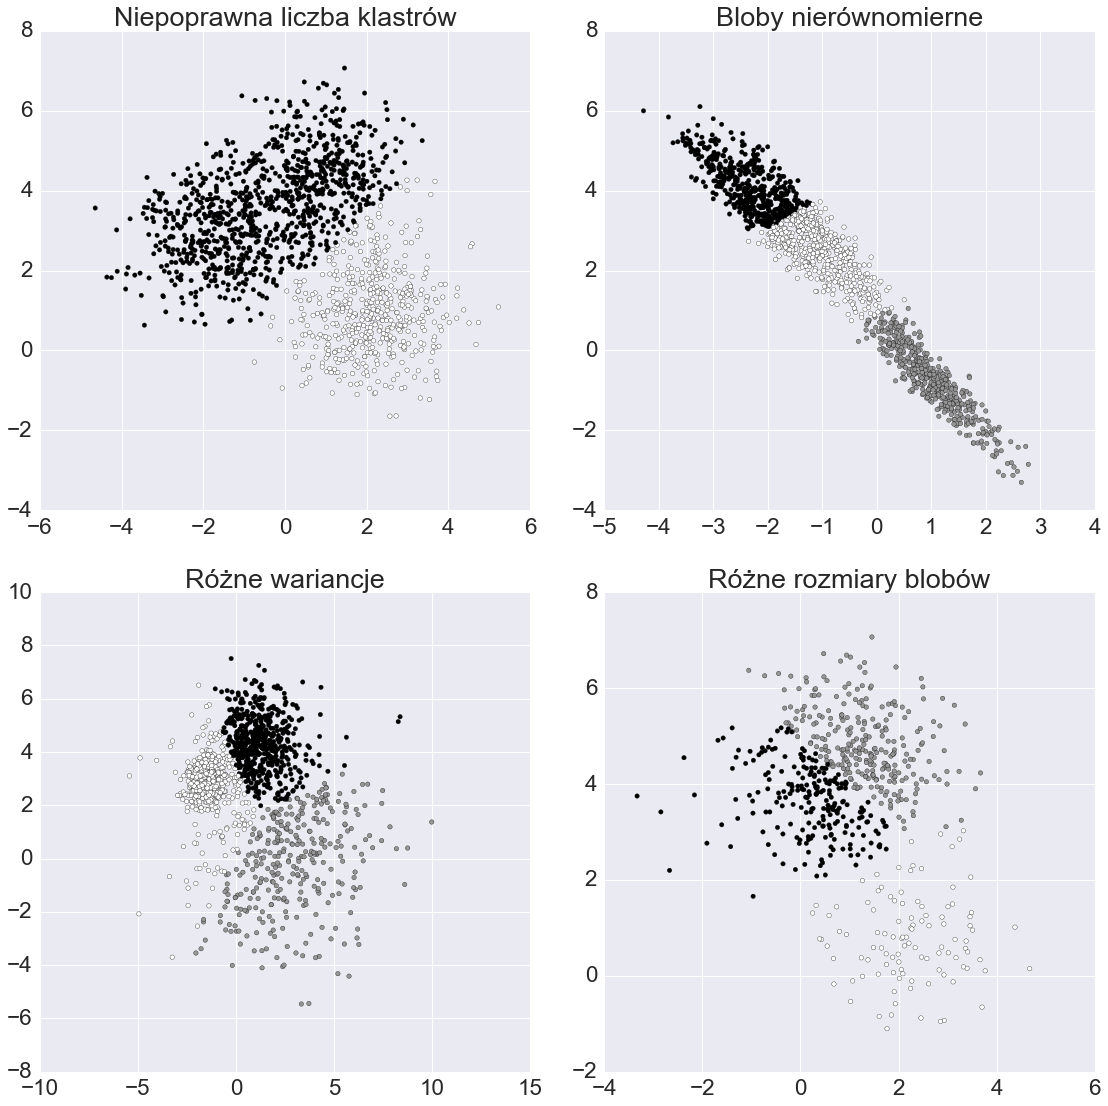

In [6]:
kmeans(random_state=0)

In [7]:
from bokeh.plotting import figure, show, vplot
from bokeh.io import output_notebook
from bokeh.charts import Scatter
from bokeh.models.markers import Circle, Cross, Triangle, Diamond, Square
from bokeh.charts import marker

In [8]:
output_notebook()

Loading BokehJS ...

In [9]:
def iris_kmeans():
    iris = datasets.load_iris()
    # print(iris)
    petal_data = iris.data[:,2:]  # tylko petal
    kmean = KMeans(n_clusters=3)
    kmean.fit(petal_data)
    
    plot = figure(width=700, height=500, title=r'Gatunki irysów', 
                  x_axis_label=r"długość płatków", 
                  y_axis_label=r"szerokość płatków")
    clus_xs = []
    clus_ys = []
    for entry in kmean.cluster_centers_:
        clus_xs.append(entry[0])
        clus_ys.append(entry[1])

    colors = ['red', 'blue', 'purple']
    plot.circle_cross(x=clus_xs, y=clus_ys, size=35, fill_alpha=0, 
                      line_width=2, color=colors)
    plot.text(text=['setosa', 'versicolor', 'virginica'], alpha=0.35,
              x=clus_xs, y=clus_ys, text_font_size='30pt')
    
    my_markers = ['diamond', 'circle', 'triangle']
    ccc = [colors[k] for k in kmean.labels_]
    mmm = [my_markers[k] for k in iris.target]
    for k, sample in enumerate(petal_data):
        plot.scatter(x=sample[0], y=sample[1], size=10, alpha=0.5,
                     color=ccc[k], marker=mmm[k])

#    plot.scatter(petal_data[:, 0], petal_data[:, 1], size=10, alpha=0.25,
#                 color=ccc)

    show(plot)

In [10]:
iris_kmeans()

### Inicjalizacja centroidów
* losowy wybór $K$ przykładów
  * pechowy wybór może spowodować bardzo powolną zbieżność
  * wymagać będzie wielokrotnego powtarzania
* __K-means++__
  * wybór początkowych centroidów jako __odległych__ od siebie
    1. niech $M=\{\}$ początkowy __pusty__ zbiór centroidów
    2. wybierz losowy $\mu_1$ spośród przykładów i dodaj do $M$
    3. dla każdego przykładu $x$, który __nie__ jest w $M$ oblicz $d(x, M)$ jako __minimalną__ odległość $x$ do jakiegokolwiek centroidu w $M$
    4. wylosuj nowy centroid $\mu$ zgodnie z rozkładem
    $$\frac{d(\mu, M)}{\sum_x d(x, M)}$$
    i dodaj do $M$
    5. powtarzaj kroki 2, 3, 4 aż do znalezienia $K$ centroidów
    
* wybór centroidów może spowodować, że któryś z klastrów będzie __pusty__
  * jeśli klaster pusty
    1. wybierz przykład $x$ najbardziej odległy od centroidu pustego klastra
    2. ustal $x$ jako centroid nowego klastra
    3. przelicz algorytm

### Zastosowanie dla kompresji obrazów
* podział obrazu na fragmenty $n\times{}n$ pikseli (tutaj $2\times2$)
* klastrowanie wynikających z tego wektorów
  * $K=200$ na obrazie środkowym i $K=4$ na obrazie po prawej
  * utworzone klastry tworzą słowa kodowe
  
* wiele z podobrazów jest bardzo podobna - redundancja w danych
* kompresja jest stratna
  * ze względu na powtarzanie się obrazów kompresja bezstartna też jest możliwa
* względnie większa powtarzalność niektórych podobrazów pozwala na nawet większą kompresję

<img src="fisher-compressed.png" width="100%"/> [Za Hastie et al.]

### Warianty k-means
1. podejście typu __batch__
  1. wylosuj początkowe centroidy
  2. zmodyfikuj przypisania przykładów do klastrów o najbliższym centroidzie
  3. popraw wartości centroidów by zminimalizować sumę odchyleń wewnątrz-klastrowych
  4. powtarzaj 2. i 3. aż do stabilizacji przypisań
  
2. wersja __inkrementacyjna__
  1. wylosuj początkowe centroidy 
  2. przypisz przykłady do klastrów określanych przez centroidy
  3. przeglądaj przykłady jeden po drugim
    1. jeśli __przeniesienie__ $x$ do innego klastra zmniejszy sumę odchyleń od centroidów
      1. przenieś przykład $x$ z klastra $C_a$ do $C_b$
      2. popraw centroidy $\mu_a$ i $\mu_b$
  4. powtarzaj aż do stabilizacji przypisań
  
  
  * kosztowniejszy od wersji _batch_ ale zwykle __efektywniejszy__
  * rozwiązanie wersji _batch_ może być poprawione przez użycie wersji _inkrementacyjnej_
    * __nie__ na odwrót!
    * wygodny kompromis:
      1. wykonać wiele epok algorytmu _batch_
      2. poprawić rozwiązanie przez wykonanie mniejszej liczby (kosztowniejszego) algorytmu _inkrementacyjnego_
      
3. wersja __online__
  1. zainicjować centroidy
  2. wylosować przykład $x$ (zgodnie z założonym rozkładem prawdopodobieństwa)
    3. znaleźć centroid $\mu$ najbliższy do $x$
    4. zmodyfikować centroid $$\mu=\mu+\eta(x-\mu)$$ dla $\eta\in{[}0,1{]}
  3. powtarzać aż do osiągnięcia warunku stopu
  
  
  * wymaga zmniejszania parametru $\eta=\eta(t)$
  * wygodny dla dużych zbiorów danych

## K-medoid
* też metoda prototypowa: __medoid__ - najbardziej reprezentatywny przkład klastra
* metoda K-means jest poprawna, gdy miarą jest suma kwadratów
  * to ogranicza do problemów z numerycznymi atrybutami
* w K-means reprezentanci klastrów są obliczani jako _średnie_
* można ograniczyć wybór centroidu do __reprezentanta spośród przykładów w klastrze__


1. dla danego klastrowania i dla każdego klastra znaleźć przykład __minimalizujący__ sumaryczną odległość do wszystkich innych przykładów w tym klastrze 
$$i_k=\underset{i:C(i)=k}{\arg\min}\sum_jD(i,j)$$
gdzie $i, j$ są indeksami przykładów, a $k$ indeksem klastra
2. dla ustalonego zestawu centroidów minimalizować sumaryczny błąd przez przypisanie przykładów do klastrów identyfikowanych przez najbliższy centroid
3. powtarzać tak długo, jak będą następować zmiany w krokach 1. i 2.


* złożoność algorytmu K-medoid jest rzędu $O(K*N_k^2)$, gdzie $N_k$ jest liczbą przykładów w $k$-tym klastrze
  * złożoność K-means jest liniowa ze względu na liczbę przykładów w klastrze $N_k$

## Jaka jest właściwa liczba klastrów ?
* oba algorytmy wymagają wyboru liczby klastrów oraz odpowiedniej inicjalizacji
* wybór liczby klastrów może zależeć od celu procesu
  * celem może być podział dóbr pomiędzy z góry znaną liczbę osób
    * wtedy zwykle wartość $K$ jest znana
  * innym celem może być opis danych statystycznych w sposób deskryptywny
    * wartość $K$ jest nieznana i musi być, razem z samym klastrowaniem, znaleziona z danych!
    
    
* zwykle rozwiązaniem może być próba analizy zachowania się wartości rozproszenia wewnątrzklastrowego $W(C)$ w zależności od liczby klastrów
  * wartość rozproszenie powinna maleć wraz ze wzrostem liczby klastrów
  * niech $K^*$ będzie "prawdziwą" ("właściwą") liczbą klastrów
  * dla $K<K^*$
    * poszczególne klastry będą zawierały grupy "prawdziwego" klastrowania
    * rozproszenie wewnątrzklastrowe będzie się zmniejszać wraz ze wzrostem liczby klastrów
  * dla $K>K^*$
    * co najmniej jeden z "naturalnych" klastrów musiał zostać podzielony na co najmniej dwa inne klastry
    * ten podział także spowoduje spadek wartości rozrzutu $W(C)$
    * ten spadek będzie (powinien być) jednak __mniejszy__ od tych wcześniejszych
  * obserwacja $W(C)$ powinna wskazywać na nagły spadek w różnicy $W(C)$ po przekroczeniu optymalnej wartości $K^\ast$
  * to podejście jest heurystyczne i czasem trudne w obserwacji
  
* __gap statistic__ (Tibshirani) porównuje dwie statystyki
  * $\log W(C)$ wraz ze wzrostem $K$ dla klastrowanych danych
  * analogiczną wartość dla danych __równomiernie rozłożonych__ na takim samym obszarze
  * właściwa wartość liczby klastrów $K$ jest wybierana tam, gdzie różnica pomiędzy dwoma statystykami jest __największa__
    * ze względu na wpływ innych czynników, doświadczenia z danymi symulowanymi są powtarzane i brana jest pod uwagę wariancja wyników: __wybierz najmniejsze $K$ takie, że różnica__ $$\displaystyle|W_S(K)-W(K)|>|W_S(K+1)-W(K+1)|-std(K+1)$$
* __elbow__ (łokieć)
  * im więcej klastrów, tym wewnątrz-klastrowe rozproszenie powinno być mniejsze
    * przykłady są bliżej centroidów
  * należy wykryć moment, w którym, wraz ze wzrostem $K$, rozrzut przestaje spadać szybko (charakterystyczny "łokieć" na wykresie)
* __silhouette__ (sylwetka)
  * to miara jak gęsto przykłady układają się wokół centroidów
    1. oblicz __spójność__ (cohesion) $coh(x)$ klastra jako średnią odległość między danym przykładem $x$ a wszystkimi innymi przykładami w tym klastrze
    2. oblicz __separację__ (separation) $sep(x)$ klastra od _najbliższego_ innego klastra jako średnią odległość między danym $x$ a wszystkimi innymi przykładami w tamtym klastrze
    3. oblicz wyznacznik __silhouette__ jako różnicę między _spójnością_ a _separacją_ względem większej z obu
    $$s=\frac{sep(x)-coh(x)}{\max(coh(x),sep(x))}$$
      * $s\in{[}-1,+1{]}$
      * idealna sylwetka jest dla $s$ bliskiego $1$, czyli dla $sep(x)>>coh(x)$
      * takie wartości odpowiadają sytuacji, gdy klastry są wyraźnie rozdzielone
      * analiza
        * uśrednione wartości $s(x)$ dla wszystkich przykładów w klastrach i uśrednione dla klastrów; wybór $K$ z największą wartością
        * analiza bez uśrednień

## Klastrowanie nakładające się
* zwykle klastrowanie jest równoważne z podziałem na __rozłączne__ skupiska
* możliwe też klastrowanie __z nakładającymi się klastrami__
  * __fuzzy__: __fuzzy C-means__ (__FCM__) (Dunn, później Bezdek)
    * każdy przykład $x$ ma przypisaną __rozmytą__ przynależność do klastrów
      * np. $(0.2, 0.7, 0.0, 0.1)$ dla $K=4$
    * FCM minimalizuje wyrażenie
    $$J=\sum_{x}\sum_{k=1}^Kw(x,k)^p\|x-\mu_k\|^2$$
    gdzie 
      * $w(x,k)$ jest wartością przynależności przykładu $x$ do klastra $k$
      $$w(x,k)=\left[\sum_{l=1}^K\left(\frac{\|x-\mu_k\|^2}{\|x-\mu_l\|^2}\right)^{\frac{2}{p-1}}\right]^{-1}$$
      * $p$ jest __wykładnikiem rozmycia__, $p>1$
        * zwykle $p=2$
        * im wyższe $p$, tym wyższe rozmycie
      * nowe centroidy obliczane są jako __ważone__ średnie przykładów przypisnych do klastrów
      $$\mu_k=\frac{\sum_x w(x,k)^p x}{\sum_x w(x,k)^p}$$
      * FCM jest w oczywisty sposób bardziej złożone

## Klastrowanie hierarchiczne


* nie wymaga podawania liczby klastrów 
  * zatrzymuje działanie po osiągnięciu jakiegoś minimum lub gdy zmiany będą bardzo nieiwelkie
* tworzy drzewo klastrów
  * daje lepszą orientację w relacjach między klastrami
    * dwa klastry zawierają się w sobie
    * dwa pochodzą od jednego klastra nadrzędnego
    
    
* __strategie__
  * przez __łączenie__ (__aglomeratywna__, __bottom_up__)
    * rozpoczyna od klastrów zbudowanych z pojedynczych przykładów
    * łączy klastry najbardziej do siebie zbliżone
  * przez __podział__ (__top-down__)
    * rozpoczyna od jednego klastra
    * dzieli klaster o największej wartości rozrzutu wewnątrz-klastrowego
    
    
* rozrzut pomiędzy sklejanymi klastrami __rośnie__ wraz z poziomem drzewa
  * __dendrogram__ ma węzły na wysokości obrazującej różnicę między ich potomkami
  * liście dendrogramu są na poziomie zerowym
  * klastry, które __łączą się wysoko__ ponad potomkami są kandydatami na naturalne klastry
    * te różnice mogą się pojawić na wielu poziomach, a stąd hierarchiczne klastrowanie zwraca całą hierarchię różnych podziałów
      * odcięcie na danym poziomie zwraca propozycję naturalnego klastrowania
      <img src="dendrogram.png" width="250%"/> [Za Hastie et al.]
    * trzeba pamiętać, że dendrogram odwzorowuje w jaki sposób dany algorytm dzieli dane, a nie jak same dane są w rzeczywistości zbudowane

### Klastrowanie aglomeratywne
* w każdym kroku dwa __najmniej niepodobne__ klastry są łączone
* w jaki sposób mierzyć niepodobieństwo dwóch klastrów $G_1$ i $G_2$?
  * po pierwsze miara odległości
  * po drugie jak uśrednić odległość przykładów?
    * __single linkage__ bierze dwa __najbliższe__ przykłady z każdego z klastrów
    $$d(G_1,G_2)=\underset{i\in{}G_1,j\in{}G_2}{\min}d_{ij}$$
      * z definicji łączy grupy, w których raptem jedna para jest blisko
      * tworzy wydłużone klastry dając fenomen __łączenia__ (__chaining__)
      * klastry nie są spójne
    * __complete linkage__ odległość dwóch najdalszych przykładów
    $$d(G_1,G_2)=\underset{i\in{}G_1,j\in{}G_2}{\max}d_{ij}$$
      * przeciwieństwo łączenia pojedynczego dając klastry o małej średnicy
    * __uśrednione__
    $$d(G_1,G_2)=\frac{1}{N_{G_1}N_{G_2}}\sum_{i\in{}G_1}\sum_{j\in{}G_2}d_{ij}\;$$
      * kompromisowe podejście
  * jeśli grupy danych wyraźnie się oddzielają, to wszystkie metody dadzą podobne wyniki   
<img src="dendrogram_linkages.png" width="250%"/> [Za Hastie et al.]

### Klastrowanie przez podział
* mniej rozpoznane od klastrowania przez łączenie
* wygodniejsze podejście gdy celem jest podział na niewielką liczbę klastrów
* można zaimplementować przez wielokrotne użycie podejscia typu K-means
  * małe $K=2$ czy $K=3$
  * może być bardzo zależne od inicjowania centroidów
  * wynikowe klastrowanie może nie mieć cechy monotoniczności w dendrogramie

## Density Based Spatial Clustering with Noise DBSCAN
* etykietuje punkty jako
  * __core point__: ma co najmniej $m$ sąsiadów wewnątrz promienia $\epsilon$
  * __border point__: jest sąsiadem punktu _core_, ale ma mniej niż $m$ własnych sąsiadów wewnatrz promienia $\epsilon$
  * __noise point__: wszystkie pozostałe
  
1. wybierz parametry $\epsilon$ oraz $m$
1. etykietuj wszystkie przykłady jako _core_, _border_, i _noise_
2. utwórz klastry
  1. dla każdego punktu _core_
  2. dla __połączonej__ grupy punktów _core), tzn. punktów core w garnicy $\epsilon$ od innych _core_
2. przypisz punkty _border_ do klastrów odpowiadających im _core_


* DBSCAN nie zakłada, że klastry mają kształt sfery
  * potrafi podzielić poprawnie zbiór _moons_
* jest wrażliwy na przekleństwo wymiarowości przy rosnącej liczbie wymiarów

## Samo-organizujące się mapy

* mapa jest zorganizowana na 2-wymiarowej powierzchni na siatce zwykle kwadratowej lub heksagonalnej
  * SOM jest rodzajem __ograniczonego__ K-means
  * w każdej mapie neurony pracują __równolegle__ przetwarzając podobne sygnały ale pochodzące z __różnych__ obszarów przestrzeni sygnałów wejściowych
  * neurony odpowiadające podobnym syganłom leżą __blisko__ siebie i mogą współpracować ze sobą przez krótkie połączenia
  * mapy kontekstowe odpowiadają redukcji wielowymiarowej informacji do niskiego wymiaru
  * położenie topologiczne neuronu w mapie SOM odpowiada konkretnej domenie informacji albo cesze z przestrzeni wejściowej (Kohonen)
  
* podstawowym celem SOM jest __mapowanie__ wielowymiarowej przestrzeni wejściowej danych do jedno- lub dwu-wymiarowej dyskretnej __mapy__
  * to mapowanie jest wykonywane w sposób adaptacyjny
  * mapa jest uporządkowana __topologicznie__
  

<img src="kohonenMap.png" width="90%"/>

### Współzawodnictwo
* dla każdego wejścia neurony obliczają swoją odpowiedź
* neuron z najwyższą wartością odpowiedzi jest określany __zwycięzcą__

### Kooperacja
* neuron zwycięzca określa położenie topologicznego sąsiedztwa aktywowanych neuronów
* sąsiedztwo określa współpracę między neuronami

### Adaptacja
* połączenia synaptyczne zwycięzcy są modyfikowane
* w kolejnych obliczeniach aktywacja adaptowanego neuronu na dany sygnał będzie __mocniejsza__



* takie podejście do samo-wzmocnienia jest typem nauczania __Hebbowskiego__:
  * _jeśli dwa neurony po dwóch stronach połączenia synaptycznego są aktywowane jednocześnie (__synchronicznie__), to siła tego połączenia jest __wzmacniana___,
  * _ jeśli dwa neurony po dwóch stronach połączenia synaptycznego są aktywowane __asynchronicznie__, to połączenie jest osłabiane albo usuwane.

---------

<img src="hebb.png" width="30%"/> 

Donald Hebb (1904-1985), kanadyjski psycholog i neurobiolog, twórca idei _nauczania hebbowskiego_ w którym pokazał udział w uczeniu pojedynczych neuronów, autot _The Organization of Behavior_ (1949)

---------

  
  
* wagi $w_i$ połączeń z wektora wejściwego do każdego z __neuronów__ na siatce są zainicjalizowane 
  * zwykle tak by leżały na 2-wymiarowej powierzchni określonej przez składniki główne
  * położenie na siatce określa __sąsiedztwo__ neuronów
  
* w każdym kroku algorytmu
  * __współzawodnictwo__
    * pobierany jest kolejny przykład wejściowy $x$
    * obliczane są __aktywacje__ wszystkich neuronów są wyliczane według $$\sum_jw_{ij}x_j$$
    * neuron o __najwyższej__ aktywacji określany jest __zwycięzcą__ z indeksem $i^*$ $$\boxed{i^*(x)=\underset{i}{\arg\min}\|x-w_i\|\;}$$
      * zwycięzcą staje się ten neuron, którego wagi $w_i$ są najbardziej podobne do przykładu
      * przykłady muszą być __znormalizowane__
    * ciągła przestrzeń wejściowa wzorców jest __mapowana__ na dyskretną przestrzeń neuronów poprzez proces współzawodnictwa miedzy neuronami
  
  * __kooperacja__
    * zwycięzca określa położenie __sąsiedztwa topologicznego__
    * neuron zwycięzca jest __modyfikowany__ tak, by jeszce bardziej przypominał przykład $$w_{i^*}=w_{i^*}+\eta(x-w_{i^*})$$ gdzie $\eta$ jest parametrem nauczania
      * parametr $\alpha$ __zmniejsza__ się w trakcie nauczania do $0$
    * istnieje wiele obserwacji w neurobiologii na to, że aktywacja neuronu w mózgu wpływa na aktywację neuronów w bezpośrednim jego sąsiedztwie
      * topologiczne sąsiedztwo jest __symetryczne__ i jego amplituda zmniejsza się wraz z odległością od centrum (tj. neuronu zwycięzcy)
    * modyfikowane są wagi neuronów sąsiadujących 
    $$\boxed{w_{i}=w_{i}+\eta{}g(i,i^{*})(x-w_i)\;}$$
  gdzie $g:\mathbb{R}\longrightarrow[0,1]$
      * $g()$ jest najczęściej funkcją gausowską
      $$g(i, i^*)=\exp\left(-\frac{d(i,i^*)}{2\sigma^2}\right)$$
        * gdzie $$d(i, i^*)=\|i-i^*\|$$ jest odległością euklidesową neuronów $i$ oraz zwycięzcy $i^*$ na siatce
        * topologiczne sąsiedztwo __zmniejsza__ się wraz z etapami uczenia, na przykład $$\sigma(t)=\sigma_0\exp(-\frac{n}{\tau_1})$$ gdzie $\tau_1$ jest stałą
      * możliwe uproszczenie do funkcji trapezowej, 
      * czasem tzw. _mexican hat_
    * na początku uczenia (duże sąsiedztwo) następuje tzw. __rozprostowywanie__ siatki wag centroidów (neuronów) na całym obszarze danych
    * w drugim etapie (małe sąsiedztwo i mały współczynnik nauczania) następuje szczegółowe dopasowywanie się do danych
  * __adaptacja__
    * wagi neuronów zmieniają się zgodnie z wektorami wejściowymi $x$
    * zgodnie z regułą Hebba wagi są wzmacniane zgodnie z parami sygnałów wejściowych (czyli $x$) i wyjsciowych (czyli aktywacji)
    * reguła Hebba prowadzi jednak do __saturacji__ i wagi są __wyłącznie wzmacniane__
    * w sieci samo-uczącej się potrzebny jest czynnik __zapominania__ (forgetting term) $f(y_i)w_i$ 
    $$\Delta{}w_i=\underbrace{\eta y_i x}_{\text{ reguła Hebba}}-\underbrace{f(y_i)w_i}_{\text{czynnik zapominania}}$$
    gdzie
    $$y_i=g(i, i^*)=\exp\left(-\frac{d(i,i^*)}{2\sigma^2}\right)$$
    * niech czynnik zapominania będzie liniowy $$f(y_i)=\eta y_i$$
    * wtedy
    $$\begin{align}
    \Delta w_i=&\eta{}y_ix-f(y_i)w_i\\
    =&\eta{}g(i,i^*)x-f(y_i)w_i\\
    &\;\;\text{zakładając}\;f(y_i)=\eta{}y_iw_i=\eta{}g(i,i^*)w_i\\
    =&\eta{}g(i, i^*)x-\eta{}y_iw_i\\
    =&\eta{}g(i,i^*)(x-w_i)
    \end{align}$$
    gdzie $$\eta=\eta(t)=\eta_0\exp\left(-\frac{t}{\tau_2}\right)$$
    * dzięki takiemu poprawianiu
      * wagi neuronów podążają za przedstawianymi przykładami
      * także tworzą się sąsiedztwa
      * powstaje topologiczne uporządkowanie

### Etapy porządkowania i adaptacji
* faza __porządkowania__
  * wstępne porządkowanie wag neuronów
  * musi być powolne - powolny spadek współczynnika nauczania $\eta$
    * na przykład $\eta_0=0.1$, $\tau_2=1000$
  * sąsiedztwo topologiczne może obejmować na poczatku __całą__ siatkę
    * na przykład $\tau_1=1000/\log\;\sigma_0$
* faza __konwergencji__
  * obejmuje szczegółowe dopasowywanie już "rozwinietej" mapy SOM
  * co najmniej kilkaset epok uczenia

### Etapy uczenia mapy Kohonena
<img src="kohonenMap-stages.png" width="65%"/>

### Cechy algorytmu SOM
* Mapa cech SOM jest dobrą aproksymacją przestrzeni wejściowej
* Mapa SOM jest topologicznie uporządkowana ponieważ położenie neuronu na siatce odpowiada konkretnej domenie lub też cesze wejściowych wzorców
* Mapa SOM odwzorowuje statystyczne wariacje przestrzeni wejsciowej: obszary w przestrzeni wejściowej z której wektory są losowane z dużym (większym niż inne) prawdopodobieństwem są mapowane na większe obszary mapy topologicznej niż wektory z obszarów o mniejszym prawdopodobieństwie; daje to dokładniejsze odwzorowanie tych obszarów
* Mapa SOM, dla danych z przestrzeni wejściowej, jest w stanie wybrać najważniejsze cechy (features) dla aproksymacji gęstości prawdopodobieństwa


* dla dwóch przykładów, jeśli aktywują naurony __bliskie__ na siatce, to można wnioskować, że przykłady są podobne
* neurony bliskie na siatce tworzą __skupiska__ neuronów odpowiadających klastrom
  * dla siatki w 1D można pokazać, że obszar zajmowany przez skupisko neuronów jest _proporcjonalny_ do naturalnego klastra
  * dla wyższych wymiarów nie ma takich dowodów
    * najlepsze przebliżenia to, że obszar na siatce jest proporcjonalny do $P^{2/3}$ rozmiaru naturalnego klastra
* niektóre funkcje sąsiedztwa mają tendencje do tworzenia _rowów_ pomiędzy sąsiadującymi klastrami
  * na przykład mexican hat
  * tzw. __u-matrix__ są wizualizacją nauczonych map SOM z __dodanymi__ pomiędzy właściwymi neuronami obszarami, gdzie stopień szarości przedstawia odległość między neuronami
* wiele problemów przy uczeniu
  * określenie odpowiedniego rozmiaru siatki
  * prędkość zmniejszania parametru nauczania oraz szerokości sąsiedztwa

<img src="websom.png" width="100%"/> [http://websom.hut.fit/]

---------
<img src="kohonen.png" width="30%"/> Teuvo Kohonen (1934-), fiński naukowiec (głównie Politechnika w Helsinkach), twórca takich algorytmów jak LVQ (Learning Vector Quantization), szczególnie map SOM

# Reguły asocjacyjne

* __reguły asocjacyjne__ to narzędzie dla analizy danych
  * zadania: dla zestawu zmiennych $X=(x_1,x_2,\dots,x_p)$ znaleźć te, które __najczęściej__ występują jednocześnie
  * celem jest utworzenie reguł o postaci $A\Longrightarrow\;B$
  * sławne reguły z początków analizy
    * {Piwo}$\Longrightarrow${Zasłony}
      * kupno piwa sugeruje większą szansę kupna zasłon
  * dla $x_i\in{[}0,1{]}$ mówi się o __analizie koszykowej__ (market basket analysis)
    * zmienne stanowią zawartość __koszyka__ i reprezentują produkty występujące jednocześnie
    * interesujące są analizy, które produkty są jednocześnie nabywane
    
    
* ogólniej: znaleźć takie wzorce $v_1,v_2,\dots,v_k$, że prawdopodobieństwo ich wystąpienia $P(X=v_i)$ będzie wysokie
  * PRZYKŁAD: mały sklep spożywczy
    * znaleźć takie zestawy produktów, że będą one jednocześnie często (z wysokim prawdopodobieństwem) kupowane przez pojedynczego klienta
  * dla problemów gdzie liczba produktów nie jest bardzo mała
    * liczba różnych wzorców będzie bardzo wysoka
    * liczba obserwacji danego wzorca $v$ będzie __zawsze__ za mała by __wiarygodnie__ ocenić $P(v)$
  * modyfikacja:
    * niech $S_i$ będzie __supportem__: zbiorem możliwych wartości zmiennej $i$
    * znaleźć $s_i\subset{}S_i$ taki, że jego prawdopodobieństwo jest wysokie
    * nowy cel: znaleźć zbiór $s_1,s_2,\dots,s_p$ taki, że
    $$P\left[\cap_i(x_i\in{}s_i)\right]$$ jest wysokie
  * taki problem jest w dalszym ciągu bardzo złożony dla dużych $p$ i dużej liczby przykładów

## Analiza koszykowa
* uproszczenie: niech $s_i$ będzie albo pojedynczą wartością, albo $s_i=S_i$


* niech $Z_1,Z_2,\dots,Z_K$ będą __fałszywymi zmiennymi__
  * jedna zmienna dla każdej możliwej wartości zmiennych $x_i$
  $$K=\sum_{i=1}^p|S_i|$$
  * $Z_j=1$ jeśli zmienna $x_i$ przyjmuje zadaną wartość
  * teraz uproszczone zadanie ma postać znalezienia podzbioru $P\subset\{1,\dots,K\}$ takiego, że prawdopodobieństwo 
  $$P\left[\cap_{k\in{}P}(Z_k=1)\right]=P\left[\prod_{k\in{}P}Z_k=1\right]$$ jest wysokie
  * zbiór $P$ nazywamy __item set__
  * liczba zmiennnych w $P$ jest jego rozmiarem
  
  
* __support__ jest frakcją transakcji w której dany produkt ($Z_k=1$) występuje
  * suport item-setu to frakcja transakcji w której ten item-set jest zawarty
  
  
* poszukiwanie reguł asocjacyjnych: znaleźć wszystkie takie item-sety $P$ utworzone ze zmiennych $Z_1,Z_2,\dots,Z_K$ z supportem $T()$ większym niż dolny próg $t$ $$\{P_j|T(P_j)>t\}$$

## Algorytm Apriori
* zaproponowany przez Agrawala w 1995 roku
  * zbiór danych składa się z __transakcji__
  * każda transakcja jest binarnym wektorem o wymiarze $|U|$
* algorytm wykorzystuje dwie proste własności:
  * dla ustalonego progu supportu $t$
    * moc zbioru $\{P_j|T(P_j)>t\}$ jest zwykle nieduża
    * (monoticzność supportu) jeśli item-set $Q$ składa się z podzbioru elementów (item-ów) zawartych w $P$, to support $Q$ musi być __większy lub równy__ supportowi $P$ $$Q\subseteq{}P\Longrightarrow{}T(Q)\geq{}T(P)$$
  * niech masło w 30% transakcji, mleko w 25%, chleb w 20%
    * $Q=${masło, mleko} w co najwyżej 25%, w rzeczywistości w 19%
    * $Q=${masło, chleb} w co najwyżej 20%, w rzeczywistości w 18%
    * $Q=${mleko, chleb} w co najwyżej 20%, w rzeczyiwstości w 15%
  * niech $P$=\{masło, mleko, chleb\}
    * $P$ w co najwyżej 15% transakcji
  * na pewno $T(Q)\geq{}T(P)$
    * monotoniczność implikuje, że każdy podzbiór częstego item-setu __też__ bedzie częsty
* item-set jest __maksymalny__ jeśli dla zadanego minimalnego poziomu supportu jest on częsty i żaden jego nadzbiór __nie jest__ już częsty
  
  

<img src="itemset.png" width="90%"/> [za Aggarwal]

### APRIORI
1. oblicz wszystkie item-sety składające się z pojedynczych elementów
  * odrzuć wszystkie te, które występują niż zadana dolna wartość suportu
  * mówimy, że takie item-sety są __częste__ (__frequent__)
3. znajdź wszystkie item-sety dwu-elementowe, które można utworzyć z pozostawionych jedno-elementowych
  * znowu wszystkie z niedostatecznym suportem mogą być odrzucone
5. powtarzaj tak długo, jak można utworzyć wystarczająco częste item-sety

* Apriori wymaga tylko __jednego__ przejścia przez wszystkie dane dla zadanej wielkości item-setów
  * istotne bo z założenia dane __nie__ mieszczą się w pamięci operacyjnej
  * jeśli dane są rzadkie, to liczba przebiegów jest niewielka
  * istnieje szereg dodatkowych usprawnień
  * to jedno z większych osiągnięć uczenia maszynowego (i data-miningu)

### Tworzenie reguł asocjacyjnych
* każdy częsty item-set {A, B} stanowi __regułę asocjacyjną__ $A\Longrightarrow{}B$
* istnieje szereg cech określających reguły
  1. __support__ $T(A\Longrightarrow{}B)$ 
    * to frakcja obserwacji poprzednika i następnika relacji w item-secie
    * aproksymuje prawdopodobieństwo wystąpeinia obu składowych $P(A,B)$ w transakcji
  2. __confidence__ $\displaystyle C(A\Longrightarrow{}B)=\frac{T(A\Longrightarrow{}B)}{T(A)}$
    * to estymacja prawdopodobieństwa warunkowego $P(B|A)$
    * wybór minimalnego confidence pozwala ograniczyć zbiór reguł
  3. __expected confidence__ $T(B)$
    * estymacja prawdopodobieństwa $P(B)$
  4. __lift__ $\displaystyle L(A\Longrightarrow{}B)=\frac{C(A\Longrightarrow{}B)}{T(B)}=\frac{T(A\Longrightarrow{}B)}{T(A)T(B)}$
    * estymacja $\displaystyle \frac{P(A,B)}{P(A)P(B)}$
    
    
    
  * reguły podlegają redukcji
    * Niech item-sety $X\subset{}Y\subset{}Z$; wtedy miedzy confidence reguł zachodzi
    $$C(Y\Longrightarrow\;Z-Y)\geq\;C(X\Longrightarrow\;Z-X)$$
      * niech dane będą reguły
      $$\begin{align}
      \{chleb\}\Longrightarrow&\;\{masło,\;mleko\}\\
      \{chleb,\;masło\}\Longrightarrow&\;\{mleko\}
      \end{align}$$
        * druga reguła jest redundantna
          * support obu jest identyczny
          * $X$={chleb}, $Y$={chleb, masło}, $Z$={chleb, masło, mleko}
          $$\begin{align}
          C(Y\Longrightarrow\;Z-Y)&=\\
          C(\{chleb,\;masło\}\Longrightarrow\;\{mleko\})&\geq{}C(X\Longrightarrow\;Z-X)\\
          &\geq{}C(\{chleb\}\Longrightarrow\;\{masło,\;mleko\})
          \end{align}$$
          * można raportować tylko reguły nie-redundantne
* Apriori zwraca bardzo dużą liczbę reguł
  * konieczny jest wybór tych właściwych
    * reguły mogą być ciekawe, jednak mieć niski support
    * albo wysoki support, ale za to być trywialne
  * liczba reguł rośnie wykładniczo, stąd wybór może być trudny
    * podniesienie minimalnego supportu może spowodować nie wygenerowanie niektórych reguł!
      * reguła wódka$\;\Longrightarrow\;$kawior ma wysoką wartość confidence
      * może nie być wygenerowana ze względu na niską sprzedaż, a wobec tego support, następnika relacji, kawioru
      
      
      